# Project 4: Product Reviews
- [Prepare Text](#prep)
- [Structure Word Matrix](#bag)
- [Build Models](#train)

In [1]:
#for working with dataset
import pandas as pd
import re

#for normalization & pre-processing of input data
from nltk import word_tokenize,download
from nltk.corpus import stopwords
from string import punctuation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#modules for implementing various machine learning models
import numpy as np
from sklearn.metrics import precision_score, recall_score,accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

#for generating graphs
import matplotlib.pyplot as plt

#for evaluating classification performance
from sklearn.metrics import multilabel_confusion_matrix

<a id="prep"></a>
# Text Preparation

To effectively use the text data for our machine learning model, we should remove punctuation, standardize word variations (tokenize), and remove simple words to focus on meaningful differences in the product reviews.

In [2]:
# Text cleansing helper functions

def remove_punctuations(text):
    text_no_punctuation = "".join([ char for char in text if char not in punctuation + ''.join([str(x) for x in range(10)]) ])
    return text_no_punctuation

def generate_tokens(text):
    tokens = word_tokenize(text.lower())
    return tokens

def remove_stopword(text):
    stop_words_list = stopwords.words('english')
    text_cleaned = ",".join([ word for word in text if word not in stop_words_list ])
    return text_cleaned

# Master function to run all cleansing operations
def all_cleansing(text):
    text = str(text)
    text = remove_punctuations(text)
    text = generate_tokens(text)
    text = remove_stopword(text)
    return text

In [3]:
df = pd.read_csv('Reviews_10pct.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,559272,B002T5TLYA,APNOO4OJ72OND,BonesighNYC,1,1,4,1280966400,Good sardines for the money,These are not your $2+ per can sardines. Nonet...
1,558859,B000LKX4ZC,A2BXMHV2B0QRCM,K. Robertson,5,5,5,1242950400,The ONLY chips I eat now!!,I have been eating these for years now and I a...
2,494505,B0048EME2Q,A2EJK4DAHK22DX,JohnnyOnDaSpot,12,12,5,1192060800,Makes NesQuik taste like paint,Listen to me! I've got nothing to gain by wri...
3,162432,B000YSQ9GC,A1SMU8R3MET82B,"Aimee A. Roseland ""12bawriter""",2,2,3,1331164800,Smells weird...,We got the 6 pack of brown rice and it smell v...
4,64307,B001EO5YAC,A3EIXID81KYE1S,"jackifus ""Jack""",4,4,5,1187136000,Fantastic Coffee at a Fantastic Price,I regularly purchase this coffee in orders of ...


In [4]:
# Evaluate min, max, mean of numerical columns
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,56845.000000,56845.000000,56845.000000,56845.000000,5.684500e+04
mean,283801.046249,1.814302,2.308787,4.183182,1.295924e+09
std,164414.334400,8.066463,8.719518,1.310467,4.823578e+07
min,12.000000,0.000000,0.000000,1.000000,9.482400e+08
25%,140902.000000,0.000000,0.000000,4.000000,1.270512e+09
50%,283416.000000,0.000000,1.000000,5.000000,1.310947e+09
75%,425952.000000,2.000000,2.000000,5.000000,1.332547e+09
max,568449.000000,559.000000,562.000000,5.000000,1.351210e+09


In [5]:
# Check for missing values
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   5
Text                      0
dtype: int64

In [6]:
df['all_text'] = df.Summary + df.Text
df['all_text_clean'] = df.all_text.apply(all_cleansing)
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,all_text,all_text_clean
0,559272,B002T5TLYA,APNOO4OJ72OND,BonesighNYC,1,1,4,1280966400,Good sardines for the money,These are not your $2+ per can sardines. Nonet...,Good sardines for the moneyThese are not your ...,"good,sardines,moneythese,per,sardines,nonethel..."


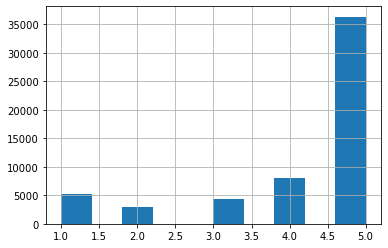

In [31]:
df.Score.hist();

<a id="bag"></a>
# Create Bag of Words Structure

We will split out independent variable (text) from dependent variable (score), then convert the text into a word count matrix using the 'bag of words' approach.

In [7]:
X = df.all_text_clean
y = df.Score

In [8]:
count_vectorizer = CountVectorizer()
transformed_vector = count_vectorizer.fit_transform(X)
print('dimensions of full word count matrix = ', transformed_vector.shape )

count_vectorizer = CountVectorizer(min_df=0.001, max_df=0.25)
transformed_vector = count_vectorizer.fit_transform(X)
print('dimensions of updated word count matrix = ', transformed_vector.shape )

dimensions of full word count matrix =  (56845, 89561)
dimensions of updated word count matrix =  (56845, 3745)


In [9]:
inv_vocab = {v:k for k, v in count_vectorizer.vocabulary_.items()}

In [10]:
tfidf_transformer = TfidfTransformer()
tfidf_vector = tfidf_transformer.fit_transform(transformed_vector)

<a id="train"></a>
# Train and Evaluate Models

We will train the following models and calculate the results, including accuracy, precision and recall:
- Logistic Regression (with parameter tuning)
- XGBoost Classifier
- XGBoost Regression

In [11]:
# Build a function for generating classification performance metrics
def summarize_classification(y_test, y_pred):
    acc = accuracy_score(y_test,y_pred,normalize=True)
    numeric_acc = accuracy_score(y_test,y_pred,normalize=False)
    prec = precision_score(y_test,y_pred,average='weighted')
    recall = recall_score(y_test,y_pred,average='weighted')
    
    print("Length of testing data: ", len(y_test))
    print("Accuracy Count: ", numeric_acc)
    print("Accuracy Score: ",acc)
    print("Precision Score: ",prec)
    print("Recall Score: ", recall)
    
    print("Confusion Matrix: \n")
    print(confusion_matrix(y_test, y_pred))

In [12]:
# Split data into train, validation and test - first 10% for testing, then 1/3 of remaining 90% for validation. Final split 70% / 30% / 10%
x_train, x_test, y_train, y_test = train_test_split(tfidf_vector, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(1/3), random_state=42)

### Logistic Regression Model

In order to classify the text reviews into one of the 5 score categories (1-5), we will apply a Logistic Regression model to the converted word count matrix.

To tune the parameters of the model for best performance, we will test 9 scenarios as combinations of the following parameters:
- L1 Ratio: 0.5, 1.0, 0.01
- Regularization Strength (C): 0.0003, 0.001, 0.003

In [13]:
# Normalizing the data using StandardScaler

scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train.toarray())
x_test_norm = scaler.transform(x_test.toarray())
x_val_norm = scaler.transform(x_val.toarray())

0.0003
0.001
0.003
best validation performance =  0.6945584613580391
regularization strength for best val performancs =  0.003


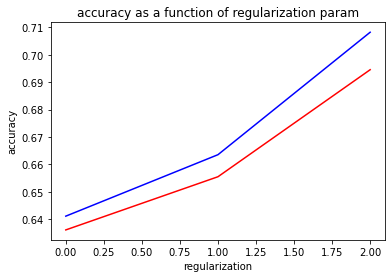

In [14]:
# Set up a loop for training and adjusting the regularization parameter to find the best model. **Reduced to 3 for improved runtime
# ~~ L1 Ratio of 0.5
reg_strength=[0.0003, 0.001, 0.003] # Actually inverse regularization strength
perf_tr = []
perf_val = []
for ratio in reg_strength:
    print(ratio)
    model = LogisticRegression(solver='saga', C=ratio, penalty='elasticnet', l1_ratio=0.5, max_iter=10000)
    model.fit(x_train_norm, y_train)
    perf_tr.append(model.score(x_train_norm, y_train))
    perf_val.append(model.score(x_val_norm, y_val))

best_num = np.argmax(np.array([perf_val]))
print('best validation performance = ', perf_val[best_num])
print('regularization strength for best val performancs = ',  reg_strength[best_num])
    
plt.plot(perf_tr, color='blue')
plt.plot(perf_val, color='red')
plt.title('accuracy as a function of regularization param')
plt.xlabel('regularization')
plt.ylabel('accuracy')
plt.show()

In [15]:
# Retrain with best regularization parameter
model_best05 = LogisticRegression(solver='saga', C=0.003, penalty='elasticnet', l1_ratio=0.5, max_iter=10000)
model_best05.fit(x_train_norm, y_train)
y_predict = model_best05.predict(x_test_norm)

# Use helper to calculate metrics
summarize_classification(y_test, y_predict)

Length of testing data:  5685
Accuracy Count:  3943
Accuracy Score:  0.6935795954265611
Precision Score:  0.6291517935689578
Recall Score:  0.6935795954265611
Confusion Matrix: 

[[ 218   16   16   23  260]
 [  60   12   21   35  135]
 [  21   10   48   87  263]
 [  18    3   17  132  692]
 [  13    1    3   48 3533]]


0.0003
0.001
0.003
best validation performance =  0.6714553770376451
regularization strength for best val performancs =  0.003


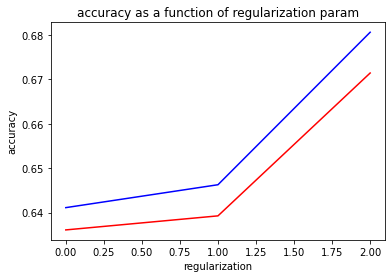

In [16]:
# Set up a loop for training and adjusting the regularization parameter to find the best model. **Reduced to 3 for improved runtime
# ~~ L1 Ratio of 1.0
reg_strength=[0.0003, 0.001, 0.003] # Actually inverse regularization strength
perf_tr = []
perf_val = []
for ratio in reg_strength:
    print(ratio)
    model = LogisticRegression(solver='saga', C=ratio, penalty='elasticnet', l1_ratio=1.0, max_iter=10000)
    model.fit(x_train_norm, y_train)
    perf_tr.append(model.score(x_train_norm, y_train))
    perf_val.append(model.score(x_val_norm, y_val))

best_num = np.argmax(np.array([perf_val]))
print('best validation performance = ', perf_val[best_num])
print('regularization strength for best val performancs = ',  reg_strength[best_num])
    
plt.plot(perf_tr, color='blue')
plt.plot(perf_val, color='red')
plt.title('accuracy as a function of regularization param')
plt.xlabel('regularization')
plt.ylabel('accuracy')
plt.show()

0.0003
0.001
0.003
best validation performance =  0.7068136507564208
regularization strength for best val performancs =  0.001


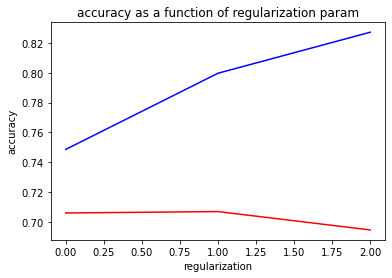

In [17]:
# Set up a loop for training and adjusting the regularization parameter to find the best model. **Reduced to 3 for improved runtime
# ~~ L1 Ratio of 0.01
reg_strength=[0.0003, 0.001, 0.003] # Actually inverse regularization strength
perf_tr = []
perf_val = []
for ratio in reg_strength:
    print(ratio)
    model = LogisticRegression(solver='saga', C=ratio, penalty='elasticnet', l1_ratio=0.01, max_iter=10000)
    model.fit(x_train_norm, y_train)
    perf_tr.append(model.score(x_train_norm, y_train))
    perf_val.append(model.score(x_val_norm, y_val))

best_num = np.argmax(np.array([perf_val]))
print('best validation performance = ', perf_val[best_num])
print('regularization strength for best val performancs = ',  reg_strength[best_num])
    
plt.plot(perf_tr, color='blue')
plt.plot(perf_val, color='red')
plt.title('accuracy as a function of regularization param')
plt.xlabel('regularization')
plt.ylabel('accuracy')
plt.show()

In [52]:
# Retrain with best values for generating test results
best_plr = LogisticRegression(solver='saga', C=0.003, penalty='elasticnet', l1_ratio=0.05, max_iter=10000).fit(x_train_norm,y_train)

y_pred = best_plr.predict(x_test_norm)

print('penalized regression performance on test data \n')
summarize_classification(y_test,y_pred)

penalized regression performance on test data 

Length of testing data:  5685
Accuracy Count:  4016
Accuracy Score:  0.7064204045734389
Precision Score:  0.668679768094168
Recall Score:  0.7064204045734389
Confusion Matrix: 

[[ 295   54   36   17  131]
 [  72   61   47   20   63]
 [  33   37  125   85  149]
 [  30   10   58  222  542]
 [  32   25   47  181 3313]]


In [57]:
# Feature importance for each category
word_list = [inv_vocab[i] for i in range(len(inv_vocab))]

feature_data = {'word':word_list, **{'imp_score'+str(i): best_plr.coef_[i] for i in range(len(best_plr.coef_))}}
importance_df = pd.DataFrame(feature_data)
importance_df.sort_values(by=['imp_score4'], axis=0, ascending=False, inplace=True)
display(importance_df.iloc[0:20])

,word,imp_score0,imp_score1,imp_score2,imp_score3,imp_score4
283,best,-0.158179,-0.062162,-0.073198,0.048116,0.297952
1908,love,-0.136387,-0.091709,-0.036383,0.022655,0.294954
851,delicious,-0.129686,-0.093132,-0.033292,0.067376,0.240886
1913,loves,-0.132212,-0.041328,-0.018697,0.030749,0.213918
1105,excellent,-0.105680,-0.054246,-0.048709,0.055406,0.205214
2342,perfect,-0.084454,-0.075045,-0.091934,0.099853,0.203319
1561,highly,0.000000,-0.025437,-0.028707,0.000000,0.190630
3670,wonderful,-0.055992,-0.077144,-0.024744,0.022818,0.187626
1180,favorite,-0.043492,-0.047162,-0.020322,0.003112,0.161157
104,amazing,-0.039825,0.000000,-0.014756,0.000000,0.160562


In [64]:
# Absolute sum of coefficients
importance_piv = importance_df.melt(id_vars='word').drop('variable', axis=1)
importance_piv.value = importance_piv.value.apply(abs)
importance_piv.groupby('word').sum().sort_values('value',ascending=False).head(10)

,value
word,
best,0.639607
love,0.582087
delicious,0.564372
perfect,0.554605
excellent,0.469255
disappointed,0.462252
ok,0.454358
stars,0.448927
loves,0.436905


### XGBoost Classifier Model

In addition to the Logistic Regression, we will apply an XGBoost classifier model to attempt to improve our accuracy. We will use `merror` (multiclass error rate) as the evaluation metric for this model.

In [25]:
# Encode labels (must start at 0)
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

In [26]:
params = {'n_estimators': 200,
         'learning_rate': 0.001,
         'objective': 'multi:softmax',
         'num_class': 5,
         'eval_metric': 'merror',
          'max_depth': 1,
         'alpha': 0,
         'nthread': 3,
         'verbosity': 1}

model = xgb.XGBClassifier(**params, use_label_encoder=False)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val, y_val)], eval_metric='merror', verbose=False)
results = model.evals_result()

best training performance 0.363317
best validation performance 0.358177


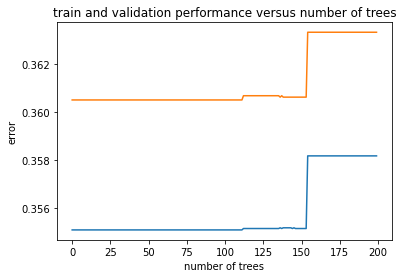

In [27]:
print('best training performance', max(results['validation_1']['merror']))
print('best validation performance', max(results['validation_0']['merror']))

results = model.evals_result()
tr_avg = results['validation_0']['merror']
val_avg = results['validation_1']['merror']
plt.plot(tr_avg)
plt.plot(val_avg)
plt.title('train and validation performance versus number of trees')
plt.xlabel('number of trees')
plt.ylabel('error')
plt.show()

In [28]:
y_te_predict = model.predict(x_test)
summarize_classification(y_test, y_te_predict)

Length of testing data:  5685
Accuracy Count:  3600
Accuracy Score:  0.633245382585752
Precision Score:  0.49445074580160153
Recall Score:  0.633245382585752
Confusion Matrix: 

[[   2    0    0    0  531]
 [   0    0    0    0  263]
 [   0    0    0    0  429]
 [   0    0    0    0  862]
 [   0    0    0    0 3598]]


C:\Users\mconan002\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
model.feature_importances_.shape
word_list = [inv_vocab[i] for i in range(len(inv_vocab))]
feature_data = {'word':word_list, 'imp_score': model.feature_importances_ }
importance_df = pd.DataFrame(feature_data)
importance_df.sort_values(by=['imp_score'], axis=0, ascending=False, inplace=True)
display(importance_df.iloc[0:20])

,word,imp_score
283,best,0.273127
1908,love,0.252123
3689,worst,0.123747
1592,horrible,0.116166
3085,stars,0.107748
2214,ok,0.077807
929,disappointed,0.025042
931,disappointing,0.024240
2499,produce,0.000000
2502,producing,0.000000


### XGBoost Regressor Model

While we are technically working with a classification problem, our categorical data is ordinal, meaning it has a progressive linear relationship. We can use a regression model to predict the score, but need to ensure to adjust the final prediction to fit the 5 categories available within the reviews.

In [37]:
params = {'n_estimators': 1000,
         'learning_rate': 0.1,
         'objective': 'reg:squarederror',
         'eval_metric': 'rmse',
         'max_depth': 10,
         'alpha': 0,
         'nthread': 4,
         'verbosity': 1}

model = xgb.XGBRegressor(**params, use_label_encoder=False)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val, y_val)], eval_metric='rmse', verbose=False)
results = model.evals_result()

best training performance 0.943634
best validation performance 0.39762


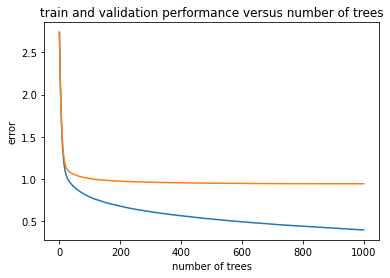

In [38]:
print('best training performance', min(results['validation_1']['rmse']))
print('best validation performance', min(results['validation_0']['rmse']))

results = model.evals_result()
tr_avg = results['validation_0']['rmse']
val_avg = results['validation_1']['rmse']
plt.plot(tr_avg)
plt.plot(val_avg)
plt.title('train and validation performance versus number of trees')
plt.xlabel('number of trees')
plt.ylabel('error')
plt.show()

In [48]:
# Predict with regression (returns float type predictions)
y_te_predict = model.predict(x_test)

# Create vectorized function and apply to align with categories
ord_conv = np.vectorize(lambda x: 0 if round(x) < 1 else 4 if round(x) > 3 else round(x))
y_te_predict = ord_conv(y_te_predict)

# Evaluate
summarize_classification(y_test, y_te_predict)

Length of testing data:  5685
Accuracy Count:  3107
Accuracy Score:  0.5465259454705365
Precision Score:  0.6979671025970314
Recall Score:  0.5465259454705365
Confusion Matrix: 

[[ 102  146  143  127   15]
 [  19   66   91   81    6]
 [   5   28  169  199   28]
 [   1   19   99  478  265]
 [   1   14  142 1149 2292]]


In [40]:
model.feature_importances_.shape
word_list = [inv_vocab[i] for i in range(len(inv_vocab))]
feature_data = {'word':word_list, 'imp_score': model.feature_importances_ }
importance_df = pd.DataFrame(feature_data)
importance_df.sort_values(by=['imp_score'], axis=0, ascending=False, inplace=True)
display(importance_df.iloc[0:20])

,word,imp_score
3689,worst,0.011834
2693,return,0.008914
2637,refund,0.008056
1145,factory,0.007703
3300,terrible,0.007681
1592,horrible,0.007070
3354,threw,0.005908
3594,waste,0.005529
929,disappointed,0.005035
931,disappointing,0.004987


# Analysis

Based on the models I trained, the Logistic Regression had the best performance with ~ 70% accuracy and slightly lower precision and recall. The variable (word) importance for the model also incorporated more variables, which I think is less likely to overfit and will generalize better to new datasets.

I used the PEP-8 online checker to identify major issues in code structure and formatting. The results are included below:

Check results
=============

- E265:12:1:block comment should start with '# '
- E265:16:1:block comment should start with '# '
- E231:17:31:missing whitespace after ','
- E265:24:1:block comment should start with '# '
- E231:26:58:missing whitespace after ','
- E501:26:80:line too long (90 > 79 characters)
- E265:30:1:block comment should start with '# '
- E265:33:1:block comment should start with '# '
- W291:39:2:trailing whitespace
- E501:40:80:line too long (219 > 79 characters)
- E201:48:36:whitespace after '['
- E501:48:80:line too long (126 > 79 characters)
- E202:48:124:whitespace before ']'
- E302:51:1:expected 2 blank lines, found 1
- E302:55:1:expected 2 blank lines, found 1
- E201:57:30:whitespace after '['
- E501:57:80:line too long (85 > 79 characters)
- E202:57:83:whitespace before ']'
- E302:61:1:expected 2 blank lines, found 1
- E703:101:16:statement ends with a semicolon
- W291:106:2:trailing whitespace
- E501:107:80:line too long (162 > 79 characters)
- E202:121:74:whitespace before ')'
- E202:125:77:whitespace before ')'
- E231:131:15:missing whitespace after ':'
- W291:143:2:trailing whitespace
- E501:144:80:line too long (105 > 79 characters)
- E231:154:32:missing whitespace after ','
- E231:154:39:missing whitespace after ','
- E231:155:40:missing whitespace after ','
- E231:155:47:missing whitespace after ','
- E231:156:34:missing whitespace after ','
- E231:156:41:missing whitespace after ','
- E231:157:33:missing whitespace after ','
- E231:157:40:missing whitespace after ','
- W293:158:1:blank line contains whitespace
- E231:161:29:missing whitespace after ','
- E231:162:30:missing whitespace after ','
- W293:164:1:blank line contains whitespace
- E501:172:80:line too long (139 > 79 characters)
- E501:173:80:line too long (100 > 79 characters)
- E501:174:80:line too long (101 > 79 characters)
- W291:178:2:trailing whitespace
- E501:179:80:line too long (159 > 79 characters)
- W291:180:2:trailing whitespace
- E501:181:80:line too long (129 > 79 characters)
- E501:199:80:line too long (131 > 79 characters)
- E225:201:13:missing whitespace around operator
- E261:201:36:at least two spaces before inline comment
- E501:206:80:line too long (106 > 79 characters)
- E501:213:80:line too long (85 > 79 characters)
- W293:214:1:blank line contains whitespace
- E501:227:80:line too long (109 > 79 characters)
- E501:238:80:line too long (131 > 79 characters)
- E225:240:13:missing whitespace around operator
- E261:240:36:at least two spaces before inline comment
- E501:245:80:line too long (106 > 79 characters)
- E501:252:80:line too long (85 > 79 characters)
- W293:253:1:blank line contains whitespace
- E501:265:80:line too long (131 > 79 characters)
- E225:267:13:missing whitespace around operator
- E261:267:36:at least two spaces before inline comment
- E501:272:80:line too long (107 > 79 characters)
- E501:279:80:line too long (85 > 79 characters)
- W293:280:1:blank line contains whitespace
- E501:293:80:line too long (132 > 79 characters)
- E231:293:124:missing whitespace after ','
- E231:298:32:missing whitespace after ','
- E231:307:23:missing whitespace after ':'
- E501:307:80:line too long (112 > 79 characters)
- E501:309:80:line too long (83 > 79 characters)
- E231:319:57:missing whitespace after ','
- E501:319:80:line too long (82 > 79 characters)
- W291:323:2:trailing whitespace
- E501:324:80:line too long (205 > 79 characters)
- E128:339:10:continuation line under-indented for visual indent
- E128:340:10:continuation line under-indented for visual indent
- E128:341:10:continuation line under-indented for visual indent
- E128:342:10:continuation line under-indented for visual indent
- E128:344:10:continuation line under-indented for visual indent
- E128:345:10:continuation line under-indented for visual indent
- E128:346:10:continuation line under-indented for visual indent
- E501:349:80:line too long (111 > 79 characters)
- E231:382:23:missing whitespace after ':'
- E202:382:74:whitespace before '}'
- E501:384:80:line too long (82 > 79 characters)
- W291:389:2:trailing whitespace
- E501:390:80:line too long (304 > 79 characters)
- E128:396:10:continuation line under-indented for visual indent
- E128:397:10:continuation line under-indented for visual indent
- E128:398:10:continuation line under-indented for visual indent
- E128:399:10:continuation line under-indented for visual indent
- E128:400:10:continuation line under-indented for visual indent
- E128:401:10:continuation line under-indented for visual indent
- E128:402:10:continuation line under-indented for visual indent
- E501:405:80:line too long (109 > 79 characters)
- E501:433:80:line too long (89 > 79 characters)
- E231:445:23:missing whitespace after ':'
- E202:445:74:whitespace before '}'
- E501:447:80:line too long (82 > 79 characters)
- W391:449:1:blank line at end of file

A number of these checks are not relevant as they relate to the markdown portions or the code or otherwise are a result of converting the Jupyter notebook to `.py` script format. Remaining lines primarly relate to whitespace around operators, which is considered best practice but often foregone in function parameters. No items in the list were considered to be major violations of PEP-8 conventions.

In [68]:
!jupyter nbconvert --to html --template full *.ipynb

[NbConvertApp] Converting notebook Project_4_Conan.ipynb to html
[NbConvertApp] Writing 458699 bytes to Project_4_Conan.html
